HUMO-LUMO energy gap prediction using Graph Convolution from Deepchem graph convolution module   9/20/2020

In [1]:
import numpy as np
from deepchem.models import GraphConvModel
import tensorflow as tf
import deepchem as dc
#from deepchem.molnet import load_delaney
import sklearn
from sklearn.metrics import r2_score
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv(r'D:/Orbital_Energies_input_data.csv')
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [3]:
  X, y  = dataset['SMILES'], dataset['Energygap']
    

In [4]:
y

0       197.749421
1       247.493942
2       164.712327
3       169.027707
4       209.569808
           ...    
2899    168.649319
2900    162.928319
2901    165.098245
2902    167.958431
2903    188.369417
Name: Energygap, Length: 2904, dtype: float64

In [5]:
X

0                                Cc1ccc(cc1)C(F)(F)F
1                                        OC(=O)CCCCl
2       CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O
3                                  Nc1ccc(Cl)c(Cl)c1
4                              C[C@@H](CCO)CCC=C(C)C
                            ...                     
2899      C(CP(c1ccccc1)c1ccccc1)P(c1ccccc1)c1ccccc1
2900                                 Brc1cccc2sccc12
2901                  CCO[C@H]1C=Cc2ccccc2N1C(=O)OCC
2902                                   s1ccc2ccccc12
2903                                   Cc1cccc(C)c1O
Name: SMILES, Length: 2904, dtype: object

In [6]:
dataset_file = "D:/Orbital_Energies_input_data.csv"

In [7]:
tasks = ['Energygap']
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
tasks=tasks, feature_field ="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

# Initialize transformers
transformers = [
dc.trans.NormalizationTransformer(
  transform_y=True, dataset=dataset)
]

print("About to transform data")
for transformer in transformers:
    dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

About to transform data


In [8]:
# Fit models
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
# Number of features on conv-mols
n_feat = 75
# Batch size of models
batch_size = 128
model = GraphConvModel(
    len(tasks), batch_size=batch_size, mode='regression')

In [9]:
# Fit trained model
model.fit(train_dataset, nb_epoch=50)

0.03058168411254883

In [10]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
Train scores
{'mean-pearson_r2_score': 0.9837543125921774}
Validation scores
{'mean-pearson_r2_score': 0.8340163885127928}


In [11]:
predicted_test = model.predict(test_dataset)
predicted_test.size

291

In [12]:
true_test = test_dataset.y
true_test.size

291

In [13]:
len(test_dataset)

291

In [14]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(true_test, predicted_test)
print('R2:', R2)

R2: 0.8435684312336118


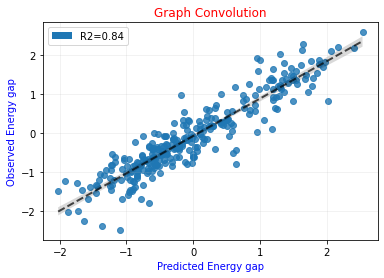

In [15]:
sn.regplot(x=predicted_test, y=true_test, line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Graph Convolution", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
plt.legend(handles=[R2])